In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.linalg import sqrtm

In [352]:
print("\nPour nettoyer les données, nous avons supprimé toutes les lignes où 'transfer_fee' était nul.")

transfer_data = pd.read_csv('transfers.csv')

print("Format des données initiales :", transfer_data.shape)
print("\nColonnes disponibles :", transfer_data.columns.tolist())

unique_last_seasons = transfer_data['transfer_season'].unique()
print("\nValeurs uniques pour 'transfer_season' allant de :", unique_last_seasons[-1], "à", unique_last_seasons[0])

columns_to_delete = ['player_id', 'transfer_season'] # le mois du transfert pourrait être intéréssant pour une étude sur une année
transfer_data = transfer_data.drop(columns=columns_to_delete, errors='ignore')

cleaned_transfer_data = transfer_data.dropna()
cleaned_transfer_data = cleaned_transfer_data[cleaned_transfer_data['transfer_fee'] != 0]

print("\nFormat après nettoyage :", cleaned_transfer_data.shape)  # Nombre d'entrées divisé par 9

unique_from_club = cleaned_transfer_data['from_club_name'].unique()
print("\nNombre de clubs différents (origine) :", unique_from_club.shape[0])

unique_to_club = cleaned_transfer_data['to_club_name'].unique()
print("\nNombre de clubs différents (destination) :", unique_to_club.shape[0])

unique_player = cleaned_transfer_data['player_name'].unique()
print("\nNombre de joueurs différents :", unique_player.shape[0])

# Assurez-vous que la colonne est au format datetime
cleaned_transfer_data['transfer_date'] = pd.to_datetime(cleaned_transfer_data['transfer_date'], errors='coerce')

# Extraire uniquement l'année
cleaned_transfer_data['transfer_date'] = cleaned_transfer_data['transfer_date'].dt.year


cleaned_transfer_data.set_index('player_name', inplace=True)

print("\nAperçu des données nettoyées :")
cleaned_transfer_data.head()



Pour nettoyer les données, nous avons supprimé toutes les lignes où 'transfer_fee' était nul.
Format des données initiales : (76860, 10)

Colonnes disponibles : ['player_id', 'transfer_date', 'transfer_season', 'from_club_id', 'to_club_id', 'from_club_name', 'to_club_name', 'transfer_fee', 'market_value_in_eur', 'player_name']

Valeurs uniques pour 'transfer_season' allant de : 93/94 à 25/26

Format après nettoyage : (8450, 8)

Nombre de clubs différents (origine) : 1461

Nombre de clubs différents (destination) : 875

Nombre de joueurs différents : 4778

Aperçu des données nettoyées :


,transfer_date,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur
player_name,,,,,,,
João Mário,2025,294,114,Benfica,Besiktas,2000000.0,3800000.0
Felix Uduokhai,2025,167,114,FC Augsburg,Besiktas,5000000.0,8500000.0
Ludovic Ajorque,2025,39,3911,1.FSV Mainz 05,Stade Brestois,2000000.0,3000000.0
Sofyan Amrabat,2025,430,36,Fiorentina,Fenerbahce,13000000.0,22000000.0
Michele Di Gregorio,2025,2919,506,Monza,Juventus,14300000.0,18000000.0


In [353]:
# Fonction pour nettoyer et convertir les valeurs en nombres positifs
def clean_and_convert(value):
    # Remove symbols and convert to positive float
    value = re.sub(r'[€+]', '', value)  # Remove currency symbols and '+'
    value = re.sub(r'-', '', value)    # Remove '-'
    value = value.replace('m', 'e6').replace('k', 'e3')  # Convert 'm' to million and 'k' to thousand
    return float(value)

print("\nPour nettoyer les données, on catégorise la colonne net_transfer_record ")

clubs_data = pd.read_csv('clubs.csv')

print(clubs_data.shape)


columns_to_delete = [
    'club_code', 'squad_size', 'foreigners_number', 'total_market_value',
    'foreigners_percentage', 'national_team_players', 'stadium_name',
    'stadium_seats', "coach_name", "filename", "url"
]
clubs_data = clubs_data.drop(columns=columns_to_delete)

net_transfer_record = clubs_data['net_transfer_record']
positive_numeric_data = [clean_and_convert(val) for val in net_transfer_record]

# Ajouter les données nettoyées à la DataFrame
clubs_data['net_transfer_record'] = positive_numeric_data

# Catégoriser les données nettoyées en 4 catégories
clubs_data['net_transfer_record'] = pd.qcut(
    clubs_data['net_transfer_record'], q=4, labels=['Low', 'Medium', 'High', 'Very High']
)

print("\nColonnes disponibles :", clubs_data.columns.tolist())
print(clubs_data['net_transfer_record'].unique())  # Vérifier les catégories uniques
print(clubs_data['domestic_competition_id'].unique())  # Vérifier les catégories uniques

clubs_data.head()



Pour nettoyer les données, on catégorise la colonne net_transfer_record 
(439, 17)

Colonnes disponibles : ['club_id', 'name', 'domestic_competition_id', 'average_age', 'net_transfer_record', 'last_season']
['High', 'Medium', 'Very High', 'Low']
Categories (4, object): ['Low' < 'Medium' < 'High' < 'Very High']
['L1' 'RU1' 'TR1' 'IT1' 'GB1' 'BE1' 'DK1' 'NL1' 'GR1' 'PO1' 'SC1' 'ES1'
 'UKR1' 'FR1']


,club_id,name,domestic_competition_id,average_age,net_transfer_record,last_season
0,105,SV Darmstadt 98,L1,25.6,High,2023
1,11127,Ural Yekaterinburg,RU1,26.5,Medium,2023
2,114,Beşiktaş Jimnastik Kulübü,TR1,26.3,Very High,2024
3,12,Associazione Sportiva Roma,IT1,26.3,Very High,2024
4,148,Tottenham Hotspur Football Club,GB1,25.4,Very High,2024


In [354]:
club_games_data = pd.read_csv('club_games.csv')
print(club_games_data.columns.tolist())
print(club_games_data.shape)

columns_to_delete = ["opponent_manager_name", "own_manager_name"]
club_games_data = club_games_data.drop(columns=columns_to_delete)
club_games_data.set_index('game_id', inplace=True)

club_games_data.head()

['game_id', 'club_id', 'own_goals', 'own_position', 'own_manager_name', 'opponent_id', 'opponent_goals', 'opponent_position', 'opponent_manager_name', 'hosting', 'is_win']
(143022, 11)


,club_id,own_goals,own_position,opponent_id,opponent_goals,opponent_position,hosting,is_win
game_id,,,,,,,,
2320450,1468,0.0,NaN,24,2.0,NaN,Home,0
2320460,1,3.0,NaN,86,1.0,NaN,Home,1
2320472,2036,4.0,NaN,72,5.0,NaN,Home,0
2321044,16,2.0,1.0,23,1.0,15.0,Home,1
2321060,23,0.0,18.0,24,2.0,11.0,Home,0


In [355]:
games_data = pd.read_csv('games.csv')
print(games_data.columns.tolist())
print(games_data.shape)

columns_to_delete = ['round', "date" ,"attendance", 'stadium', "url", "home_club_goals", "away_club_goals", "home_club_manager_name", "away_club_manager_name", "referee", "home_club_name", "away_club_name", "home_club_position", "away_club_position"]
games_data = games_data.drop(columns=columns_to_delete)

print(games_data['season'].unique()) # valeur allant de 2013 à 2014
print(games_data['competition_id'].unique())
print(games_data['competition_type'].unique())

# On pourrait avec home et away club formation et aggregate voire si la formation d'une équipe joue un role dans la victoire ce dont je ne pense pas
games_data.set_index('game_id', inplace=True)
games_data.head()



['game_id', 'competition_id', 'season', 'round', 'date', 'home_club_id', 'away_club_id', 'home_club_goals', 'away_club_goals', 'home_club_position', 'away_club_position', 'home_club_manager_name', 'away_club_manager_name', 'stadium', 'attendance', 'referee', 'url', 'home_club_formation', 'away_club_formation', 'home_club_name', 'away_club_name', 'aggregate', 'competition_type']
(71511, 23)
[2013 2014 2015 2016 2017 2012 2018 2019 2020 2021 2022 2023 2024]
['L1' 'RU1' 'BE1' 'FR1' 'GB1' 'SC1' 'UKR1' 'PO1' 'ES1' 'NL1' 'TR1' 'GR1'
 'IT1' 'POCP' 'EL' 'UKRP' 'CL' 'CDR' 'CIT' 'FAC' 'GRP' 'CLQ' 'ELQ' 'NLP'
 'DK1' 'DFB' 'RUP' 'DKP' 'POSU' 'SFA' 'GBCS' 'SUC' 'KLUB' 'ECLQ' 'USC'
 'UCOL' 'CGB' 'SCI' 'DFL' 'FRCH' 'RUSS' 'UKRS' 'NLSC' 'BESC']
['domestic_league' 'domestic_cup' 'international_cup' 'other']


,competition_id,season,home_club_id,away_club_id,home_club_formation,away_club_formation,aggregate,competition_type
game_id,,,,,,,,
2321044,L1,2013,16,23,4-2-3-1,4-3-2-1,2:1,domestic_league
2321060,L1,2013,23,24,4-3-2-1,4-2-3-1,0:2,domestic_league
2321086,L1,2013,4,16,4-2-3-1,4-2-3-1,1:1,domestic_league
2321152,L1,2013,44,33,4-2-3-1,4-2-3-1,0:2,domestic_league
2321205,L1,2013,41,39,4-2-3-1,4-4-2 Diamond,2:3,domestic_league


In [356]:
game_club_data = pd.merge(games_data, club_games_data, on="game_id")
print(game_club_data.shape)
columns_to_delete = ["opponent_goals", "own_goals", "club_id", "opponent_id", 'competition_id','home_club_formation', 'away_club_formation', "hosting"]
# Pas besoin des formations de même pour hosting, il n' ya pas d'objectif de prédictions
game_club_data = game_club_data.drop(columns=columns_to_delete)
game_club_data.head()

(143022, 16)


,season,home_club_id,away_club_id,aggregate,competition_type,own_position,opponent_position,is_win
game_id,,,,,,,,
2321044,2013,16,23,2:1,domestic_league,1.0,15.0,1
2321044,2013,16,23,2:1,domestic_league,15.0,1.0,0
2321060,2013,23,24,0:2,domestic_league,18.0,11.0,0
2321060,2013,23,24,0:2,domestic_league,11.0,18.0,1
2321086,2013,4,16,1:1,domestic_league,15.0,1.0,0


In [357]:

# Nettoyer les scores dans la colonne 'aggregate'
game_club_data['aggregate'] = game_club_data['aggregate'].fillna('0:0')

# Filtrer uniquement les lignes avec des scores valides
valid_scores = game_club_data['aggregate'].str.contains(r'^\d+:\d+$', na=False)
game_club_data = game_club_data[valid_scores]

# Supprimer les lignes avec des NaN critiques (par exemple, 'own_position' ou 'opponent_position')
game_club_data = game_club_data.dropna(subset=['own_position', 'opponent_position'])

# Assurez-vous que les colonnes numériques ne contiennent pas de NaN (remplissage par 0 si nécessaire)
game_club_data['own_position'] = game_club_data['own_position'].fillna(0).astype(int)
game_club_data['opponent_position'] = game_club_data['opponent_position'].fillna(0).astype(int)

# Séparer les scores en buts domicile et extérieur
game_club_data[['home_goals', 'away_goals']] = game_club_data['aggregate'].str.split(':', expand=True).astype(int)

# Calcul des buts marqués à domicile
home_goals = game_club_data.groupby(['season', 'home_club_id'])['home_goals'].sum().reset_index()
home_goals.rename(columns={'home_club_id': 'club_id', 'home_goals': 'total_goals'}, inplace=True)

# Calcul des buts marqués à l'extérieur
away_goals = game_club_data.groupby(['season', 'away_club_id'])['away_goals'].sum().reset_index()
away_goals.rename(columns={'away_club_id': 'club_id', 'away_goals': 'total_goals'}, inplace=True)

# Fusionner les buts à domicile et à l'extérieur
total_goals = pd.concat([home_goals, away_goals]).groupby(['season', 'club_id'])['total_goals'].sum().reset_index()

# Calcul des victoires à domicile (is_win == 1 pour home_club_id)
home_wins = game_club_data[game_club_data['is_win'] == 1].groupby(['season', 'home_club_id'])['is_win'].count().reset_index()
home_wins.rename(columns={'home_club_id': 'club_id', 'is_win': 'wins'}, inplace=True)

# Calcul des victoires à l'extérieur (is_win == 0 pour away_club_id)
away_wins = game_club_data[game_club_data['is_win'] == 0].groupby(['season', 'away_club_id'])['is_win'].count().reset_index()
away_wins.rename(columns={'away_club_id': 'club_id', 'is_win': 'wins'}, inplace=True)

# Fusionner les victoires domicile et extérieur
total_wins = pd.concat([home_wins, away_wins]).groupby(['season', 'club_id'])['wins'].sum().reset_index()

# Calcul de la moyenne et du meilleur classement par saison
positions = game_club_data.groupby(['season', 'home_club_id'])['own_position'].agg(
    median_position='median', #best_position='min'
).reset_index()
positions.rename(columns={'home_club_id': 'club_id'}, inplace=True)

# Fusion des statistiques (buts, victoires, positions)
final_stats = total_goals.merge(total_wins, on=['season', 'club_id'], how='left')
final_stats = final_stats.merge(positions, on=['season', 'club_id'], how='left')

final_stats['wins'] = final_stats['wins'].fillna(0).astype(int)
final_stats['median_position'] = round(final_stats['median_position'])
# Résultat final sans NaN
final_stats = final_stats.dropna()
# Afficher le tableau final
final_stats.head()


,season,club_id,total_goals,wins,median_position
0,2012,4,78,33,12.0
1,2012,5,134,43,9.0
2,2012,11,144,38,6.0
3,2012,12,142,36,7.0
4,2012,13,130,41,3.0


In [358]:
# Création des datas pour transferts entrants et sortants
cleaned_transfer_data_receiver = cleaned_transfer_data.rename(columns={'to_club_id': 'club_id'})
cleaned_transfer_data_receiver = cleaned_transfer_data_receiver.rename(columns={'to_club_name': 'club_name'})
cleaned_transfer_data_receiver['club_role'] = 'receiver'
columns_to_delete = ["from_club_name"]
cleaned_transfer_data_receiver = cleaned_transfer_data_receiver.drop(columns=columns_to_delete)

cleaned_transfer_data_sender = cleaned_transfer_data.rename(columns={'from_club_id': 'club_id'})
cleaned_transfer_data_sender = cleaned_transfer_data_sender.rename(columns={'from_club_name': 'club_name'})
cleaned_transfer_data_sender['club_role'] = 'sender'
columns_to_delete = ["to_club_name"]
cleaned_transfer_data_sender = cleaned_transfer_data_sender.drop(columns=columns_to_delete)

# Fusion des transferts entrants et sortants dans un seul merged_data
transfers = pd.concat([cleaned_transfer_data_receiver, cleaned_transfer_data_sender], ignore_index=True)
columns_to_delete = ["from_club_id", "to_club_id"]
transfers = transfers.drop(columns=columns_to_delete)

merged_data = pd.merge(
    final_stats,
    transfers,
    how='left',
    left_on=['season', 'club_id'],
    right_on=['transfer_date', 'club_id']
)

columns_to_delete = ["club_id", "transfer_date"]
merged_data = merged_data.drop(columns=columns_to_delete)

# Supprimer les lignes où 'transfer_fee' est manquant
merged_data = merged_data.dropna(subset=['transfer_fee'])
print(merged_data.shape)
merged_data.head()

(10425, 8)


,season,total_goals,wins,median_position,club_name,transfer_fee,market_value_in_eur,club_role
1,2012,134,43,9.0,AC Milan,3300000.0,1750000.0,receiver
2,2012,134,43,9.0,AC Milan,4000000.0,4500000.0,receiver
3,2012,134,43,9.0,AC Milan,42000000.0,38000000.0,sender
4,2012,134,43,9.0,AC Milan,1800000.0,4000000.0,sender
5,2012,144,38,6.0,Arsenal,12000000.0,13000000.0,receiver


In [359]:
receiver_club_data = merged_data[merged_data['club_role'] == 'receiver'].drop(columns=["club_role"])
sender_club_data = merged_data[merged_data['club_role'] == 'sender'].drop(columns=["club_role"])
receiver_club_data.head()

,season,total_goals,wins,median_position,club_name,transfer_fee,market_value_in_eur
1,2012,134,43,9.0,AC Milan,3300000.0,1750000.0
2,2012,134,43,9.0,AC Milan,4000000.0,4500000.0
5,2012,144,38,6.0,Arsenal,12000000.0,13000000.0
6,2012,142,36,7.0,AS Roma,1250000.0,1500000.0
9,2012,130,41,3.0,Atlético Madrid,13500000.0,7500000.0


In [360]:
from sklearn.cross_decomposition import CCA

# Définir les deux ensembles de variables
X_receiver = receiver_club_data[['total_goals', 'wins', 'median_position']]  # Performances
Y_receiver = receiver_club_data[['transfer_fee']]  # Transferts

<Axes: >

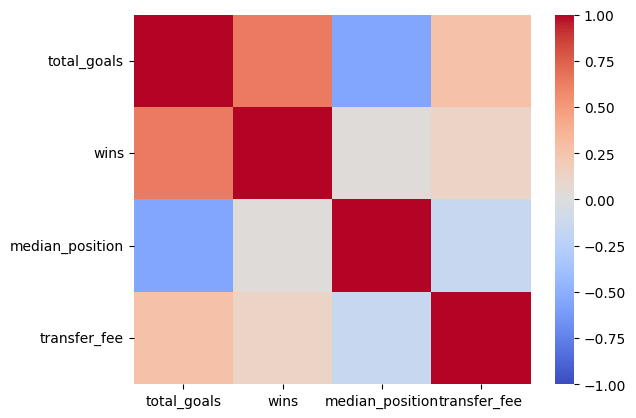

In [361]:
df_transfer = pd.concat([X_receiver, Y_receiver],axis=1)

# Calculate the correlation matrix
corr_matrix_transfer = df_transfer.corr()


# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix_transfer, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)

In [362]:
def empirical_cov_mat(X,Y):
    nx = X.shape[0]
    ny = Y.shape[0] 
        
    X_c = X - np.mean(X, axis=0)
    Y_c = Y - np.mean(Y, axis=0)
    if nx != ny:
        print('ERROR : X,Y have not the same sample size')
    else:
        S_XX = (X_c.T.dot(X_c))/nx
        S_YY = (Y_c.T.dot(Y_c))/nx
        S_XY = (X_c.T.dot(Y_c))/nx
        S_YX = S_XY.T
    return S_XX,S_YY,S_XY,S_YX

def canonical_correlation_analysis(X, Y):
    
    # Step 1: Compute covariance matrices
    S_xx,S_yy,S_xy,S_yx = empirical_cov_mat(X,Y)
    
    # Step 2: Compute the inverse and sqrt of the covariance matrices
    if S_xx.size==1:
        S_xx_inv=1/S_xx
    else:
        S_xx_inv = np.linalg.inv(S_xx)
    if S_yy.size==1:    
        S_yy_inv=1/S_yy
    else:
        S_yy_inv = np.linalg.inv(S_yy)

    if S_xx_inv.size==1:
        SQx= np.sqrt(S_xx_inv)
    else:
        SQx =sqrtm(S_xx_inv)
    if S_yy_inv.size ==1 :
        SQy=np.sqrt(S_yy_inv)
    else:
        SQy =sqrtm(S_yy_inv)
        
    M = SQx.dot(S_xy).dot(SQy)

    U,ccs,Vt = np.linalg.svd(M)

    a = SQx.dot(U)
    b = SQy.dot(Vt.T)

    C_X = (X - np.mean(X, axis=0)).dot(a)

    C_Y = (Y - np.mean(Y, axis=0)).dot(b)


    return C_X, C_Y, a, b, ccs

In [363]:
X_c, Y_c, a, b, sing_value = canonical_correlation_analysis(np.array(X_receiver), np.array(Y_receiver))


Matrix Correlation of Canonical Variables :


<Axes: >

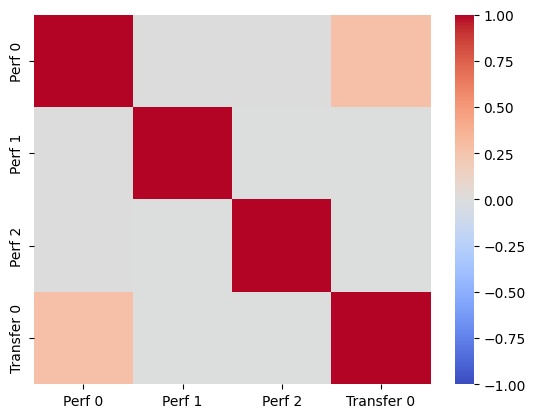

In [364]:
# Plot canonical correlations
print("\nMatrix Correlation of Canonical Variables :")

df_T = pd.DataFrame()

for k in range(3):
    df_T['Perf '+str(k)] = X_c[:,k]
for k in range(Y_receiver.shape[1]):
    df_T['Transfer '+str(k)] = Y_c[:,k]

new_cross_corr = df_T.corr()
sns.heatmap(new_cross_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)



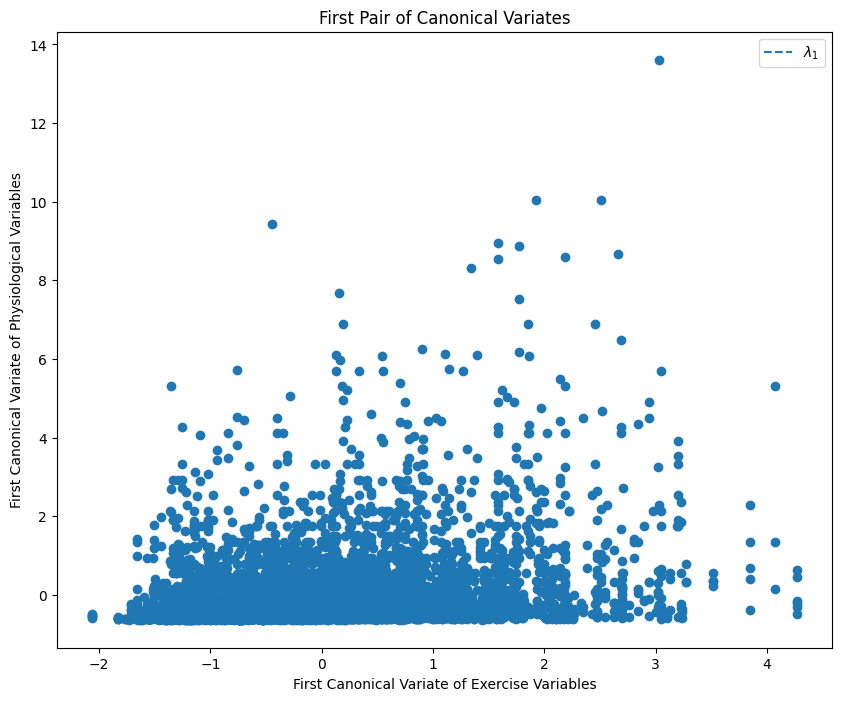

In [365]:
# Plot the first pair of canonical variates
plt.figure(figsize=(10, 8))
plt.scatter(X_c[:, 0], Y_c[:, 0])
plt.plot(np.linspace(-1.5, 1.5,100), sing_value[0]*np.linspace(-1.5, 1.5,100),'--',label=r'$\lambda_1$')
plt.xlabel('First Canonical Variate of Exercise Variables')
plt.ylabel('First Canonical Variate of Physiological Variables')
plt.title('First Pair of Canonical Variates')
plt.legend()
plt.show()

# # Scatterplot for the second pair of canonical variates
# plt.figure(figsize=(10, 8))
# plt.scatter(X_c[:, 1], Y_c[:, 1])
# plt.xlabel('Second Canonical Variate of Exercise Variables')
# plt.ylabel('Second Canonical Variate of Physiological Variables')
# plt.title('Second Pair of Canonical Variates')
# plt.grid(True)
# plt.show()


In [366]:
X_c, Y_c, a, b, sing_value = canonical_correlation_analysis(np.array(X_receiver), np.array(Y_receiver))

In [367]:
def plot_correlation_circles(X, Y, X_c, Y_c, X_names=None, Y_names=None, X_can=None, Y_can=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Correlations for X original variables with X canonical variables
    x_loadings_x = np.corrcoef(X.T, X_c.T)[:X.shape[1], X.shape[1]:]
    
    # Correlations for Y original variables with X canonical variables
    y_loadings_x = np.corrcoef(Y.T, X_c.T)[:Y.shape[1], X_c.shape[1]:]

    # Correlations for X original variables with Y canonical variables
    x_loadings_y = np.corrcoef(X.T, Y_c.T)[:X.shape[1], Y_c.shape[1]:]
    
    # Correlations for Y original variables with Y canonical variables
    y_loadings_y = np.corrcoef(Y.T, Y_c.T)[:Y.shape[1], Y_c.shape[1]:]

    # Plot relative to X canonical variables
    ax1.set_title('Correlation Circle (X Canonical Variables)')
    for i in range(X.shape[1]):
        ax1.arrow(0, 0, x_loadings_x[i, 0], x_loadings_x[i, 1], 
                  head_width=0.05, head_length=0.05, fc='blue', ec='blue', length_includes_head=True)
        if X_names is None:
            ax1.text(x_loadings_x[i, 0]*1.15, x_loadings_x[i, 1]*1.15, f'X{i+1}', color='blue')
        else:
            ax1.text(x_loadings_x[i, 0]*1.15, x_loadings_x[i, 1]*1.15, X_names[i], color='blue')
    for i in range(Y.shape[1]):
        ax1.arrow(0, 0, y_loadings_x[i, 0], 0,  # CC2 contribution for Y is zero since it has only one dimension
                  head_width=0.05, head_length=0.05, fc='red', ec='red', length_includes_head=True)
        if Y_names is None:
            ax1.text(y_loadings_x[i, 0]*1.15, 0.15, f'Y{i+1}', color='red')
        else:
            ax1.text(y_loadings_x[i, 0]*1.15, 0.15, Y_names[i], color='red')

    ax1.add_artist(plt.Circle((0, 0), 1, color='gray', fill=False))
    ax1.axhline(y=0, color='k', linestyle='--')
    ax1.axvline(x=0, color='k', linestyle='--')
    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-1.2, 1.2)
    ax1.set_aspect('equal')
    if X_can is not None:
        ax1.set_xlabel('X (' + X_can + ') CC1')
        ax1.set_ylabel('X (' + X_can + ') CC2')
    else:
        ax1.set_xlabel('X CC1')
        ax1.set_ylabel('X CC2')

    # Plot relative to Y canonical variables
    ax2.set_title('Correlation Circle (Y Canonical Variables)')
    for i in range(X.shape[1]):
        ax2.arrow(0, 0, x_loadings_y[i, 0], 0,  # CC2 contribution is zero for single-variable Y
                  head_width=0.05, head_length=0.05, fc='blue', ec='blue', length_includes_head=True)
        if X_names is None:
            ax2.text(x_loadings_y[i, 0]*1.15, 0.15, f'X{i+1}', color='blue')
        else:
            ax2.text(x_loadings_y[i, 0]*1.15, 0.15, X_names[i], color='blue')
    for i in range(Y.shape[1]):
        ax2.arrow(0, 0, y_loadings_y[i, 0], 0,  # CC2 contribution is zero for single-variable Y
                  head_width=0.05, head_length=0.05, fc='red', ec='red', length_includes_head=True)
        if Y_names is None:
            ax2.text(y_loadings_y[i, 0]*1.15, 0.15, f'Y{i+1}', color='red')
        else:
            ax2.text(y_loadings_y[i, 0]*1.15, 0.15, Y_names[i], color='red')

    ax2.add_artist(plt.Circle((0, 0), 1, color='gray', fill=False))
    ax2.axhline(y=0, color='k', linestyle='--')
    ax2.axvline(x=0, color='k', linestyle='--')
    ax2.set_xlim(-1.2, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_aspect('equal')
    if Y_can is not None:
        ax2.set_xlabel('Y (' + Y_can + ') CC1')
        ax2.set_ylabel('Y (' + Y_can + ') CC2')
    else:
        ax2.set_xlabel('Y CC1')
        ax2.set_ylabel('Y CC2')

    plt.tight_layout()
    plt.show()

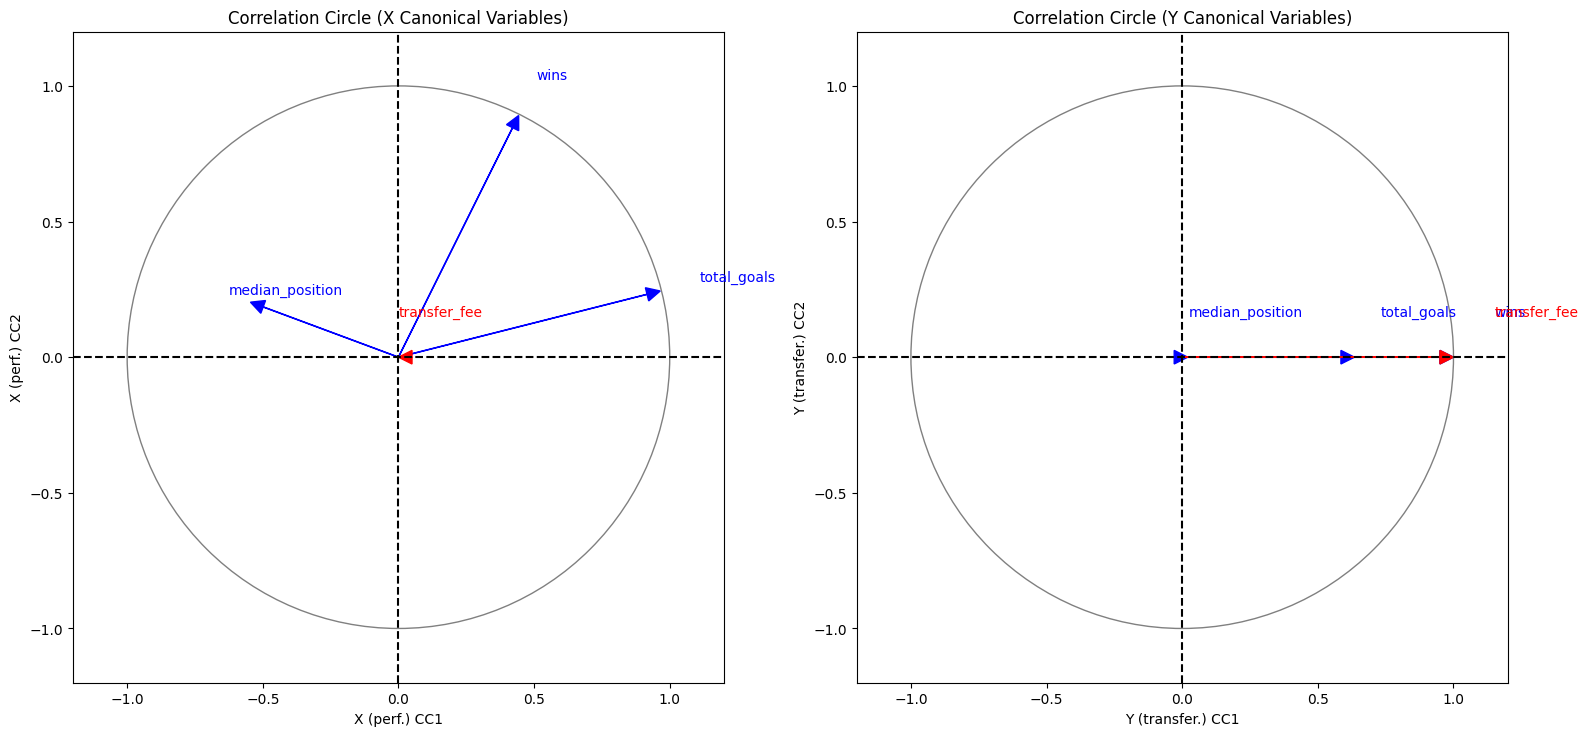

In [368]:
plot_correlation_circles( X_receiver, Y_receiver, X_c,Y_c,X_names= np.array(['total_goals', 'wins', 'median_position']), Y_names = np.array(['transfer_fee']), X_can = 'perf.', Y_can= 'transfer.')